In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#Training set:  852 triples annotated as correct and incorrect

data = pd.read_csv('featuresAnnotatedTriples.csv',sep="\t", decimal=",", index_col=False)
data=data[(data['VALIDATION']<3)]
print("Size: ", data.shape)
#data1=data[data['ORIGIN']=='f']
data.head(3)

Size:  (852, 69)


,2,3,4,5,6,7,8,9,10,11,...,VALIDATION,ORIGIN,CLUSTER,TABLE,CELL,NAME_COL1,NAME_COL2,ENTITY_COL1,PREDICATE,ENTITY_COL2
0,9,11,6,1.833333,24,-1,2,5,5,1.0,...,2,t,0,203221.9,13:-1:2,protag_article@3,candid@3,https://en.wikipedia.org/wiki/Electoral_result...,P1346 :winner@en,https://en.wikipedia.org/wiki/Voter_turnout :Q...
1,8,6,6,1.000000,11,-1,1,5,5,1.0,...,2,t,0,238845.8,4:-1:1,protag_article@3,2__parti@3,https://en.wikipedia.org/wiki/Gravesham_Boroug...,P488-1 :chairperson@en,https://en.wikipedia.org/wiki/Labour_Party_(UK...
2,8,13,6,2.166667,28,-1,2,6,6,1.0,...,2,t,0,242238.8,17:-1:2,protag_article@3,candid@3,https://en.wikipedia.org/wiki/Electoral_result...,P488 :chairperson@en,https://en.wikipedia.org/wiki/Voter_turnout :Q...


I applied normalization over some feautures, but I didn't get to much difference

In [3]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


In [4]:
#Next features are not used
#21 number entities subject cell
#22 number entities object cell
#23 ratio 21/22
#38 exist relation in KB
#43 number links subject cell
#44 number links object cell
# Features not normalized:
#7 subject column index
#8 object column index 
#26 &27 formatting present in cells (0,1)
#37 relation from title article (0,1)
#39 object is in range of predicate (0,1)
#40 subject is in domain of predicate (0,1)
#64 Inverse predicate
noImportant=['21','22','23','38','43','44']
noNormalized=['7','8', '26', '27', '37','39','40','64','VALIDATION']
def filterFeatures(data):
    #Adding feature for inverse property
    data['64']=data.PREDICATE.str.contains('-1')
    data['64']=np.where(data['64'],0,1)
    data.head(2)
    r1 = [str(i) for i in np.arange(2,65) if str(i) if str(i) not in noImportant and str(i) not in noNormalized]
    r1.append('VALIDATION')
    x=data[r1]
    r1 = [c for c in list(x.columns) if c not in noNormalized]
    d1=x[r1]
    #Normalized features
    xn=normalize(d1)
    xf=pd.concat([xn, data[noNormalized]], axis=1)
    fcols=[c for c in list(xf.columns) if c!='VALIDATION']
    X=xf[fcols]
    Y=xf['VALIDATION']
    colnames={n:int(n) for n in list(X.columns)}
    #Numeric name features and sorting
    X=X.rename(columns=colnames)
    X = X.sort_index(axis=1)    
    #Final dataFrame
    xf=pd.concat([X, Y], axis=1)
    print("Number of correct triples: ", xf[xf['VALIDATION']==1].shape)
    print("Number of incorrect triples: ", xf[xf['VALIDATION']==2].shape)
    return xf
xf=filterFeatures(data)
X=xf.iloc[:,:-1].values
Y=xf['VALIDATION'].values

Number of correct triples:  (245, 58)
Number of incorrect triples:  (607, 58)


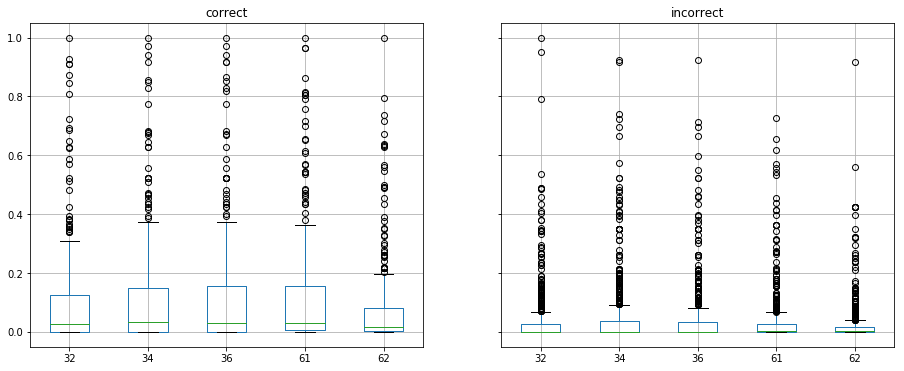

In [5]:
#Features validation to idenfify outliers

#32 Ratio number rows where predicate holds / total rows
#34 Ratio number relations where predicate holds / total relations
#36 Ratio number unique relations where predicate holds / total unique relations
#61 Ratio number rows where predicate holds / total rows in cluster
#62 Ratio number relations where predicate holds / total relations in cluster

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 6]

c=xf[xf['VALIDATION']==1][[32,34,36,61,62]]
c.describe()

i=xf[xf['VALIDATION']==2][[32,34,36,61,62]]
i.describe()

c['key'] = 'correct'
i['key'] = 'incorrect'

DF = pd.concat([c,i],keys=['correct','incorrect'])
DFGroup = DF.groupby(['key'])
ax=DFGroup.boxplot()
plt.show()

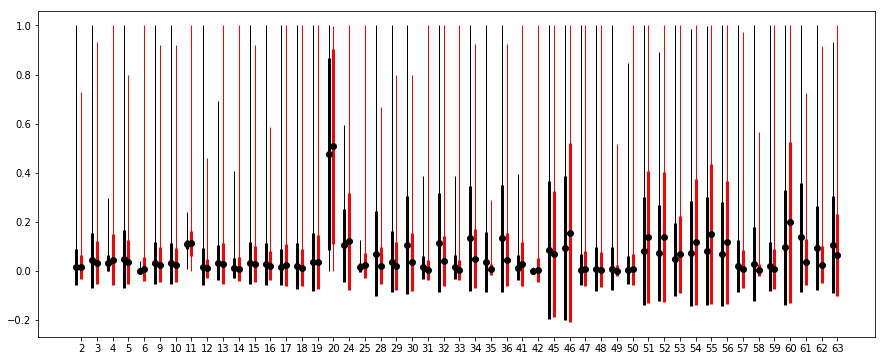

In [6]:
#Comparison all features
#CORRECT TRIPLES
c=xf[xf['VALIDATION']==1].iloc[:,:-1]
inoNormalized=[int(noNormalized[n]) for n in range(len(noNormalized)-1)]
cols=[col for col in list(c.columns) if col not in inoNormalized]
c=c[cols]
mins = c.min().values
maxes = c.max().values
means = c.mean().values
std = c.std().values

plt.errorbar(np.arange(len(list(c.columns))), means, std, fmt='ok', lw=3)
plt.errorbar(np.arange(len(list(c.columns))), means, [means - mins, maxes - means],
             fmt='.k', ecolor='black', lw=1)

#INCORRECT TRIPLES
i=xf[xf['VALIDATION']==2].iloc[:,:-1]
inoNormalized=[int(noNormalized[n]) for n in range(len(noNormalized)-1)]
cols=[col for col in list(i.columns) if col not in inoNormalized]
i=i[cols]

mins = i.min().values
maxes = i.max().values
means = i.mean().values
std = i.std().values


plt.errorbar([i+0.3 for i in range(len(list(i.columns)))], means, std, fmt='ok',ecolor='red', lw=3)
plt.errorbar([i+0.3 for i in range(len(list(i.columns)))], means, [means - mins, maxes - means],
             fmt='.k', ecolor='red', lw=1)
plt.xticks([i+0.3 for i in range(len(list(i.columns)))], [str(i) for i in list(i.columns)])
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


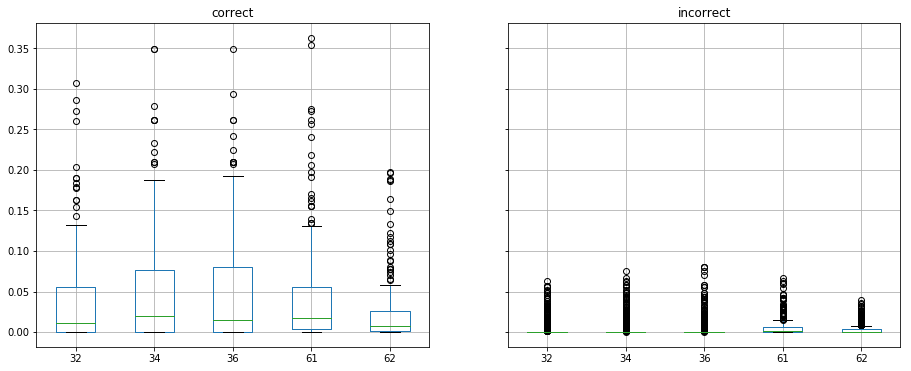

In [7]:

#Delete outiliers that are out of interquartile (Greater than 0.75 and less than 0.25) on specific features

c=xf[xf['VALIDATION']==1][[32,34,36,61,62]]
Q1 = c.quantile(0.25)
Q3 = c.quantile(0.75)
IQR = Q3 - Q1
dfoc = c[~((c < (Q1 - 1.5 * IQR)) |(c > (Q3 + 1.5 * IQR))).any(axis=1)]
dfoc['key'] = 'correct'
i=xf[xf['VALIDATION']==2][[32,34,36,61,62]]
Q1 = i.quantile(0.25)
Q3 = i.quantile(0.75)
IQR = Q3 - Q1
dfo = i[~((i < (Q1 - 1.5 * IQR)) |(i > (Q3 + 1.5 * IQR))).any(axis=1)]
dfo['key'] = 'incorrect'

DF = pd.concat([dfoc,dfo],keys=['correct','incorrect'])
DFGroup = DF.groupby(['key'])
ax=DFGroup.boxplot()
plt.show()

In [8]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedKFold
def classify(X, Y, weighted=True):
    warnings.simplefilter(action='ignore', category=FutureWarning)    
    # Cross validation with 40 splits,  each time with 20% as validation set.
    kf = StratifiedShuffleSplit(n_splits=40, test_size=0.2) 
    cl1 = KNeighborsClassifier(n_neighbors=1)
    cl2 = DecisionTreeClassifier()
    cl3 = RandomForestClassifier(max_depth=10,random_state=101, max_features=None, min_samples_leaf=3)
    cl4=  SVC(kernel='linear')
    cl5 = GaussianNB()
    p1= p2= p3= p4 =p5=0 
    r1=r2=r3=r4=r5=0
    f1=f2=f3=f4=f5=0
    cont=0
    pacum=[]

    for train_index, test_index in kf.split(X, Y): 
            #print("Train:", train_index, "Validation:", test_index) 
            X_train, X_test = X[train_index], X[test_index] 
            y_train, y_test = Y[train_index], Y[test_index]

            #cl1 = KNeighborsClassifier(n_neighbors=1)
            #cl2 = DecisionTreeClassifier()
            #cl3 = RandomForestClassifier(max_depth=10,max_features=None, min_samples_leaf=3)
            #cl4=  SVC(kernel='linear')

            #print(X_train)
            #print('----')
            #print(y_train)
            #print('KNN---------------')
            #cl1 = KNeighborsClassifier(n_neighbors=1)
            #X_train, X_test, y_train, y_test = train_test_split(xf, y, test_size=0.3, random_state=4)
            cl1.fit(X_train, y_train)
            y_pred = cl1.predict(X_test)
            if weighted:
                labels=[1,2]
            else:
                labels=[1]
                
            p1+=precision_score(y_test, y_pred, labels=labels,average='weighted') 
            r1+=recall_score(y_test, y_pred, labels=labels,average='weighted') 
            f1+=f1_score(y_test, y_pred, labels=labels,average='weighted') 
            #print('KNN')
            #print(classification_report(y_test, y_pred))
            #print('Decision Tree --------------')

            cl2.fit(X_train, y_train)    
            y_pred=cl2.predict(X_test)
            p2+=precision_score(y_test, y_pred, labels=labels,average='weighted') 
            r2+=recall_score(y_test, y_pred, labels=labels,average='weighted') 
            f2+=f1_score(y_test, y_pred, labels=labels,average='weighted') 
            #print('Decision Tree')
            #print(classification_report(y_test, y_pred))
            #print (sorted(zip(map(lambda x: round(x, 4), cl2.feature_importances_), list(xf.columns)), 
            #         reverse=False))

            cl3.fit(X_train, y_train)
            y_pred=cl3.predict(X_test)
            ps=precision_score(y_test, y_pred, labels=labels,average='weighted') 
            pacum.append(ps)
            p3+=ps 
            r3+=recall_score(y_test, y_pred, labels=labels,average='weighted') 
            f3+=f1_score(y_test, y_pred, labels=labels,average='weighted') 
            #print('Random')
            #print(cl3.feature_importances_)
            #print (sorted(zip(map(lambda x: round(x, 4), cl3.feature_importances_), list(xf.columns)), 
            #         reverse=False))
            #print(classification_report(y_test, y_pred))

            #cl4.fit(X_train, y_train)        
            #y_pred=cl4.predict(X_test)    
            #p4+=precision_score(y_test, y_pred, average='weighted') 
            #r4+=recall_score(y_test, y_pred, average='weighted') 
            #f4+=f1_score(y_test, y_pred, average='weighted') 
            #print('Logistic')
            #print(classification_report(y_test, y_pred))

            cl5.fit(X_train, y_train)
            y_pred=cl5.predict(X_test)
            p5+=precision_score(y_test, y_pred, labels=labels,average='weighted') 
            r5+=recall_score(y_test, y_pred, labels=labels,average='weighted') 
            f5+=f1_score(y_test, y_pred, labels=labels,average='weighted') 
            #print('Naive Bayes')
            #print(classification_report(y_test, y_pred))


            cont+=1
            #print('Set y: ', [ip for ip in y_test if ip==1])
    print('***  KNN  ***')
    print('Precision: ', p1/cont)
    print('Recall: ', r1/cont)
    print('F1-score: ', f1/cont)
    print('***  Decision Tree  ***')
    print('Precision: ', p2/cont)
    print('Recall: ', r2/cont)
    print('F1-score: ', f1/cont)
    print('***  Random Forest  ***')
    print('Precision: ', p3/cont)
    print('Recall: ', r3/cont)
    print('F1-score: ', f3/cont)
    print('***  Naive Bayes  ***')
    print('Precision: ', p5/cont)
    print('Recall: ', r5/cont)
    print('F1-score: ', f5/cont)
        #print(pacum)
        #print('***  SVC  ***')
        #print('Precision: ', p4/cont)
        #print('Recall: ', r4/cont)
        #print('F1-score: ', f4/cont)
            #print(classification_report(y_test, y_pred))



In [9]:
#Measure evaluated for correct triples
dt=pd.concat([dfoc,dfo])
print("Total triples without outliers: ", dt.shape)
print("Total correct triples without outliers: ", dt[dt['key']=='correct'].shape)
print("Total incorrect triples without outliers: ", dt[dt['key']=='incorrect'].shape)
dt['key']=np.where(dt['key']=='correct',1, 2)
setToTrain=set(dt.index.tolist())
dt=xf[xf.index.isin(list(setToTrain))]
X=dt.iloc[:,:-1].values
Y=dt['VALIDATION'].values
classify(X,Y, False)

Total triples without outliers:  (655, 6)
Total correct triples without outliers:  (195, 6)
Total incorrect triples without outliers:  (460, 6)
***  KNN  ***
Precision:  0.5167272231336083
Recall:  0.5102564102564104
F1-score:  0.511133503786425
***  Decision Tree  ***
Precision:  0.5561665750783102
Recall:  0.5634615384615388
F1-score:  0.511133503786425
***  Random Forest  ***
Precision:  0.6195900862125371
Recall:  0.5217948717948719
F1-score:  0.5624371111005202
***  Naive Bayes  ***
Precision:  0.6141412431861472
Recall:  0.6083333333333335
F1-score:  0.6040096378751717


In [10]:
#Training Random Forest:
setAll=set(xf.index.tolist())
setFiltered=setAll-setToTrain
outliers=xf[xf.index.isin(list(setFiltered))]
print("Outliers: ", outliers.shape[0])
RF=  RandomForestClassifier(max_depth=3,random_state=101, max_features=None, min_samples_leaf=3)
RF.fit(X,Y)
X_test=outliers.iloc[:,:-1].values
y_test=outliers['VALIDATION'].values
y_pred=RF.predict(X_test)
print(classification_report(y_test, y_pred))
print("OUTLIERS")
print(y_test)
print("PREDICTED")
print(y_pred)

Outliers:  197
              precision    recall  f1-score   support

           1       0.27      1.00      0.43        50
           2       1.00      0.08      0.15       147

   micro avg       0.31      0.31      0.31       197
   macro avg       0.64      0.54      0.29       197
weighted avg       0.81      0.31      0.22       197

OUTLIERS
[2 2 1 2 2 2 1 2 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 1 2 2 1 2
 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 1 2 2 2
 1 2 1 2 2 2 2 1 2 2 1 1 2 2 2 2 2 2 1 1 1 2 1 1 2 1 2 2 2 2 2 2 1 2 2 1 2
 2 1 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2
 2 2 2 2 2 2 2 1 2 2 1 2 2 1 2 2 2 2 1 2 2 2 2 1 1 1 1 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2]
PREDICTED
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

#### PROBABILITY THRESHOLD EVALUATION, TESTING OVER OUTILIERS

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
def probability_analysis(X,Y, X_test=None, y_test=None, label=1):    
    if X_test is not None:
        X_train=X
        y_train=Y
        y_score = RF.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=0)
        y_score = RF.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    labels=[1,2]
    th=dict()
    #for i in labels:
    fpr[label], tpr[label], th[label] = roc_curve(y_test, y_score,  pos_label=label)
    roc_auc[label] = auc(fpr[label], tpr[label])
    print(roc_auc)
    #print("TH: ", th)
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel(), pos_label=1)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print(roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr[label], tpr[label], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[label])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example - Random Forest')
    plt.legend(loc="lower right")
    plt.show()

{1: 0.2872108843537415}
{1: 0.2872108843537415, 'micro': 0.2872108843537415}


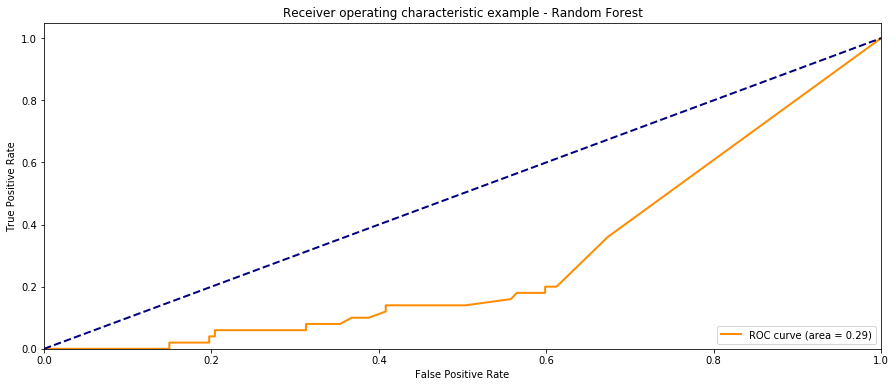

In [12]:
#We get probability
probability_analysis(X,Y, X_test, y_test)

{1: 0.2397790055248619}
{1: 0.2397790055248619, 'micro': 0.2397790055248619}


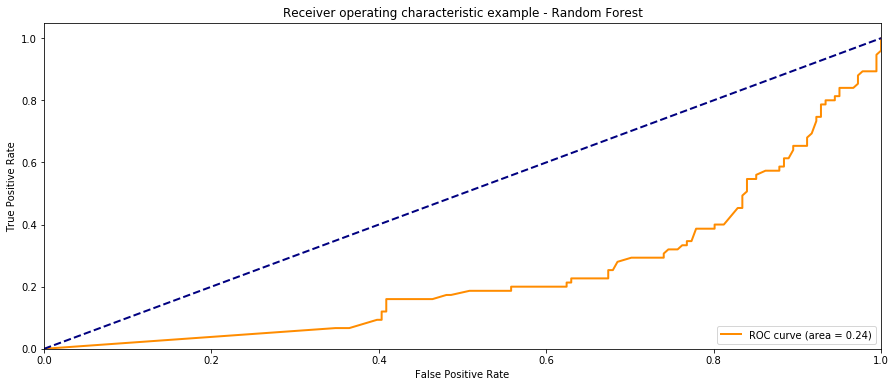

In [13]:
# Similar results are obtained for all data. 
X=xf.iloc[:,:-1].values
Y=xf['VALIDATION'].values
probability_analysis(X,Y)

In [14]:
#Outliers data
data[data.index.isin(list(setFiltered))].iloc[:,56:].head()

,61,62,63,VALIDATION,ORIGIN,CLUSTER,TABLE,CELL,NAME_COL1,NAME_COL2,ENTITY_COL1,PREDICATE,ENTITY_COL2,64
46,0.116939,0.406470,2,2,t,2,114126.11,4:-1:1,protag_article@3,spancol@4,https://en.wikipedia.org/wiki/List_of_Latvian_...,P17 :country@en,https://en.wikipedia.org/wiki/Latvia :Q211,1
53,0.116939,0.406470,2,2,t,2,27054.44,14:-1:1,protag_article@3,spancol@4,https://en.wikipedia.org/wiki/2000%E2%80%9301_...,P17 :country@en,https://en.wikipedia.org/wiki/Cameroon :Q1009,1
64,0.602756,0.533935,2,1,f,2,560380.10,3:3:2,player@3,posit@3,https://en.wikipedia.org/wiki/Vladimir_Nikolov...,P413 :position played on team / speciality@en,https://en.wikipedia.org/wiki/Midfielder :Q193592,1
65,0.116939,0.406470,2,2,f,2,562929.3,3:-1:1,protag_article@3,spancol@4,https://en.wikipedia.org/wiki/Fort_Worth_Vaque...,P17 :country@en,https://en.wikipedia.org/wiki/Mexico :Q96,1
71,0.602756,0.533935,2,2,f,2,669590.3,3:3:2,player@3,posit@3,https://en.wikipedia.org/wiki/Berliner_AK_07 :...,P413 :position played on team / speciality@en,https://en.wikipedia.org/wiki/Defender_(associ...,1


In [15]:
#No filtered data with all features: 32,34,36,61,62 
# Measure evaluated with correct Triples
X=xf.iloc[:,:-1].values
Y=xf['VALIDATION'].values
classify(X,Y, False)

***  KNN  ***
Precision:  0.5163562789148286
Recall:  0.48979591836734687
F1-score:  0.5005950110568372
***  Decision Tree  ***
Precision:  0.5211269752137768
Recall:  0.5204081632653061
F1-score:  0.5005950110568372
***  Random Forest  ***
Precision:  0.6520428999372844
Recall:  0.4811224489795918
F1-score:  0.5494783105127967
***  Naive Bayes  ***
Precision:  0.4774987970682475
Recall:  0.5928571428571427
F1-score:  0.516088775690212


### Important!

In [16]:
X=xf.copy()
del X[31]
del X[32]
del X[33]
del X[34]
del X[35]
del X[36]
X=X.iloc[:,:-1].values
Y=xf['VALIDATION'].values
classify(X,Y, False)

***  KNN  ***
Precision:  0.4905638747567152
Recall:  0.4637755102040816
F1-score:  0.4747195196099808
***  Decision Tree  ***
Precision:  0.5164092215243935
Recall:  0.5275510204081633
F1-score:  0.4747195196099808
***  Random Forest  ***
Precision:  0.6602824683943539
Recall:  0.49132653061224485
F1-score:  0.5600246558032159
***  Naive Bayes  ***
Precision:  0.40942176204537395
Recall:  0.7551020408163265
F1-score:  0.5283272888436505


### Adding correct triples that exist in Wikidata

In [17]:
dataCorrect = pd.read_csv('sample300Frame.csv',sep="\t", decimal=",", index_col=False)
print("Size: ", data.shape)
#data1=data[data['ORIGIN']=='f']
dataCorrect.head(3)

Size:  (852, 70)


,1,2,3,4,5,6,7,8,9,10,...,VALIDATION,ORIGIN,CLUSTER,TABLE,CELL,NAME_COL1,NAME_COL2,ENTITY_COL1,PREDICATE,ENTITY_COL2
0,0,4,12,6,2.0,36,2,3,12,12,...,1,f,72,836544.4,1:2:3,name@3,nation@3,https://en.wikipedia.org/wiki/Marlies_G%C3%B6h...,P1532 :country for sport@en,https://en.wikipedia.org/wiki/East_Germany :Q1...
1,0,2,10,5,2.0,17,-1,1,6,6,...,1,f,372,568763.2,4:-1:1,protag_article@3,titl@3,https://en.wikipedia.org/wiki/Hangin%27_Tough ...,P361-1 :part of@en,https://en.wikipedia.org/wiki/Cover_Girl_(New_...
2,0,1,10,4,2.5,28,1,2,9,9,...,1,f,36,242469.1,6:1:2,rider@3,team@3,https://en.wikipedia.org/wiki/Nikki_Harris :Q2...,P54 :member of sports team@en,https://en.wikipedia.org/wiki/Boels%E2%80%93Do...


In [18]:
#Append new data to initial group.

xf1=filterFeatures(dataCorrect)
xfNew=xf.append(xf1)
xfNew.shape
X=xfNew.iloc[:,:-1].values
Y=xfNew['VALIDATION'].values
classify(X,Y, False)

Number of correct triples:  (300, 58)
Number of incorrect triples:  (0, 58)
***  KNN  ***
Precision:  0.7127361177966711
Recall:  0.6809633027522936
F1-score:  0.6954905983605016
***  Decision Tree  ***
Precision:  0.767489139906308
Recall:  0.7573394495412842
F1-score:  0.6954905983605016
***  Random Forest  ***
Precision:  0.8474039994712106
Recall:  0.7392201834862385
F1-score:  0.7884827430604517
***  Naive Bayes  ***
Precision:  0.860668718739268
Recall:  0.5912844036697248
F1-score:  0.6999699773194443


Adding correct triples the performance is good, but it is necesary to know that the most of triples in dataset are generated with predicates extracted from cluster and correct triples extracted from cluster are less than 10%

In [30]:
#If features of table are not included, the results are similar. 
#Without table features.
test=xfNew.copy()
del test[31]
del test[32]
del test[33]
del test[34]
del test[35]
del test[36]
X=test.iloc[:,:-1].values
Y=test['VALIDATION'].values
classify(X,Y, False)

***  KNN  ***
Precision:  0.7041822626801248
Recall:  0.6637614678899083
F1-score:  0.6825282862236216
***  Decision Tree  ***
Precision:  0.7613982594889075
Recall:  0.773394495412844
F1-score:  0.6825282862236216
***  Random Forest  ***
Precision:  0.8417141497830283
Recall:  0.757110091743119
F1-score:  0.7959659226995216
***  Naive Bayes  ***
Precision:  0.8497576420021501
Recall:  0.5612385321100917
F1-score:  0.6743354885751984


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


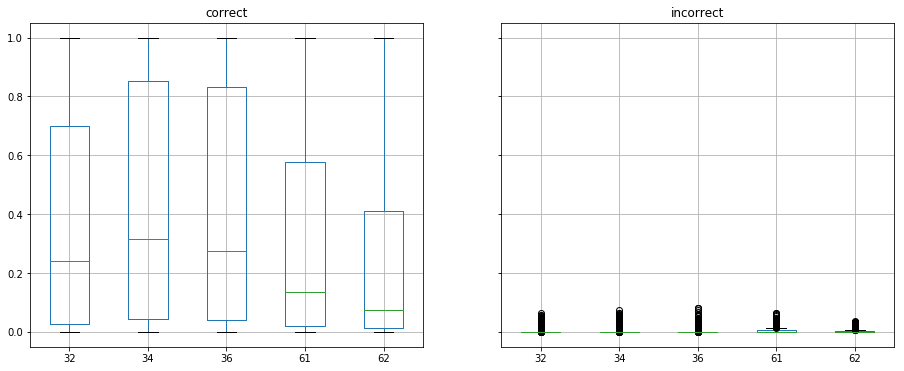

In [20]:
c=xfNew[xfNew['VALIDATION']==1][[32,34,36,61,62]]
Q1 = c.quantile(0.25)
Q3 = c.quantile(0.75)
IQR = Q3 - Q1
dfoc = c[~((c < (Q1 - 1.5 * IQR)) |(c > (Q3 + 1.5 * IQR))).any(axis=1)]
dfoc['key'] = 'correct'

i=xfNew[xfNew['VALIDATION']==2][[32,34,36,61,62]]
Q1 = i.quantile(0.25)
Q3 = i.quantile(0.75)
IQR = Q3 - Q1
dfo = i[~((i < (Q1 - 1.5 * IQR)) |(i > (Q3 + 1.5 * IQR))).any(axis=1)]
dfo['key'] = 'incorrect'

DF = pd.concat([dfoc,dfo],keys=['correct','incorrect'])
DFGroup = DF.groupby(['key'])
ax=DFGroup.boxplot()
plt.show()

In [21]:
#Training Naive Bayes:
#Measure evaluated for correct triples
dt=pd.concat([dfoc,dfo])
print("Total triples without outliers: ", dt.shape)
print("Total correct triples without outliers: ", dt[dt['key']=='correct'].shape)
print("Total incorrect triples without outliers: ", dt[dt['key']=='incorrect'].shape)
dt['key']=np.where(dt['key']=='correct',1, 2)



setAll=set(xfNew.index.tolist())
setToTrain=set(dt.index.tolist())
alld=xfNew[xfNew.index.isin(list(setToTrain))]
X=alld.iloc[:,:-1].values
Y=alld['VALIDATION'].values

setFiltered=setAll-setToTrain
outliers=xfNew[xfNew.index.isin(list(setFiltered))]
print("Outliers: ", outliers.shape[0])
NB = GaussianNB()
NB.fit(X,Y)
X_test=outliers.iloc[:,:-1].values
y_test=outliers['VALIDATION'].values
y_pred=NB.predict(X_test)
print(classification_report(y_test, y_pred))
print("OUTLIERS")
print(y_test)
print("PREDICTED")
print(y_pred)

Total triples without outliers:  (1005, 6)
Total correct triples without outliers:  (545, 6)
Total incorrect triples without outliers:  (460, 6)
Outliers:  129
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.53      0.70       129

   micro avg       0.53      0.53      0.53       129
   macro avg       0.50      0.27      0.35       129
weighted avg       1.00      0.53      0.70       129

OUTLIERS
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
PREDICTED
[1 2 2 2 1 2 1 1 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 1 2 1 1 2 2 1 2 2 1 1 2 1
 1 2 1 2 2 2 2 2 2 2 1 1 1 2 1 2 2 2 1 2 1 1 1 2 1 1 2 1 2 1 2 2 2 1 2 2 2
 2 2 2 2 2 2 1 1 2 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 2 1 2 2 1 2 1
 1 2 1

/home/jhomara/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{1: 0.0686789712039648}
{1: 0.0686789712039648, 'micro': 0.0686789712039648}


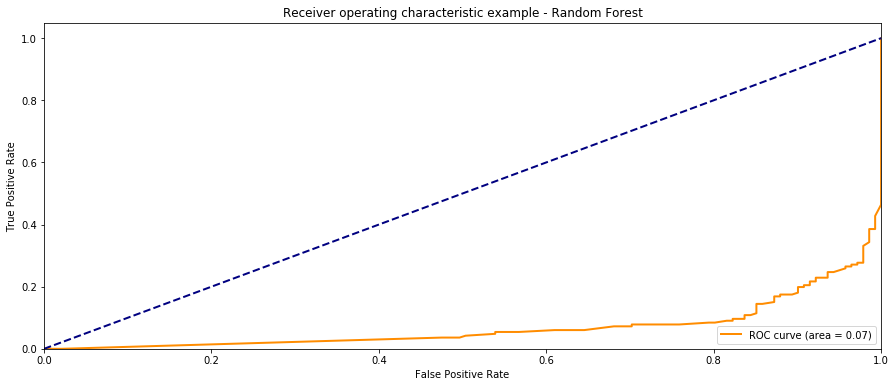

In [22]:
probability_analysis(X,Y)

In [23]:
#Saving trained model
import pickle
cl5 = GaussianNB()
cl5.fit(X,Y)
filename = 'trainedModelNoise2.sav'
pickle.dump(cl5, open(filename, 'wb'))

### Some stats

In [24]:
Y.shape

(1023,)

KNN: 0.755591 (0.024341)
DT: 0.815756 (0.024646)
RF: 0.846912 (0.025913)
SVM: 0.843180 (0.022269)
GNB: 0.793136 (0.025979)


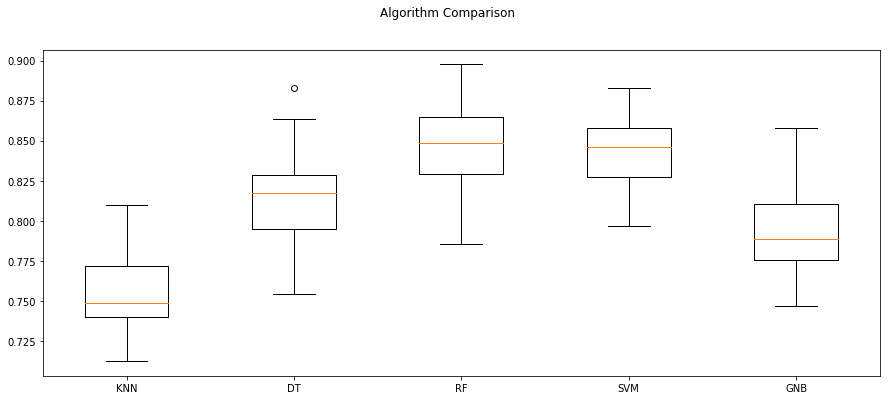

In [25]:
# Compare Algorithms Weighted average
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

seed = 7
models = []
cl1 = KNeighborsClassifier(n_neighbors=1)
cl2 = DecisionTreeClassifier()
cl3 = RandomForestClassifier(max_depth=10,max_features=None, min_samples_leaf=3)
cl4=  SVC(kernel='linear')
cl5 = GaussianNB()
models.append(('KNN',cl1))
models.append(('DT', cl2))
models.append(('RF', cl3))
models.append(('SVM', cl4))
models.append(('GNB', cl5))
results = []
names = []
scoring = 'f1_weighted'
for name, model in models:
    #kfold = model_selection.KFold(n_splits=40, random_state=seed)
    kfold = StratifiedShuffleSplit(n_splits=40, test_size=0.2) 
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [26]:
#Graph decision Tree 
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
model = RandomForestClassifier(n_estimators=10)
Xtree=xf[[14,17,20,19,36,8,25,24,6,4,35,34,18,32,13,7,11,33,10,15,9,3,2]]
print(Xtree.head(2))
Xtreev=Xtree.values

model.fit(Xtreev, y)
fnames=[str(fn) for fn in list(Xtree.columns)]
cnames=[str(v) for v in set(y.values)]
print(fnames)
print(cnames)

estimator = model.estimators_[0]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = fnames,
                class_names = cnames,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')"""

"\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.tree import export_graphviz\nmodel = RandomForestClassifier(n_estimators=10)\nXtree=xf[[14,17,20,19,36,8,25,24,6,4,35,34,18,32,13,7,11,33,10,15,9,3,2]]\nprint(Xtree.head(2))\nXtreev=Xtree.values\n\nmodel.fit(Xtreev, y)\nfnames=[str(fn) for fn in list(Xtree.columns)]\ncnames=[str(v) for v in set(y.values)]\nprint(fnames)\nprint(cnames)\n\nestimator = model.estimators_[0]\n\n# Export as dot file\nexport_graphviz(estimator, out_file='tree.dot', \n                feature_names = fnames,\n                class_names = cnames,\n                rounded = True, proportion = False, \n                precision = 2, filled = True)\n\n# Convert to png using system command (requires Graphviz)\nfrom subprocess import call\ncall(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])\n\n# Display in jupyter notebook\nfrom IPython.display import Image\nImage(filename = 'tree.png')"

estimator 1
learning curve
learning curve2
estimator 2
learning curve
learning curve2


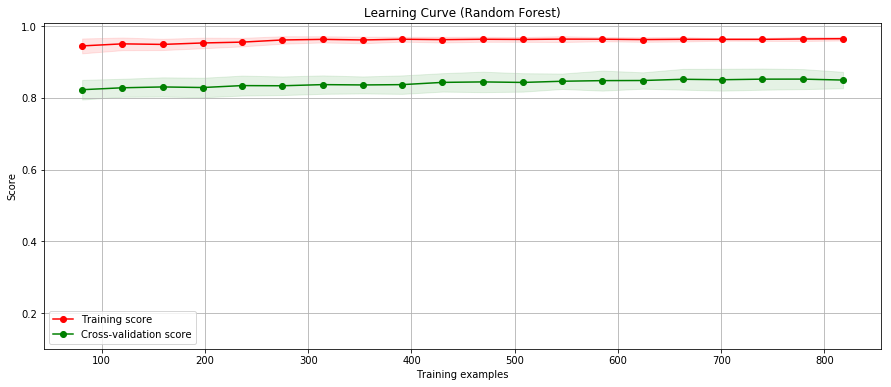

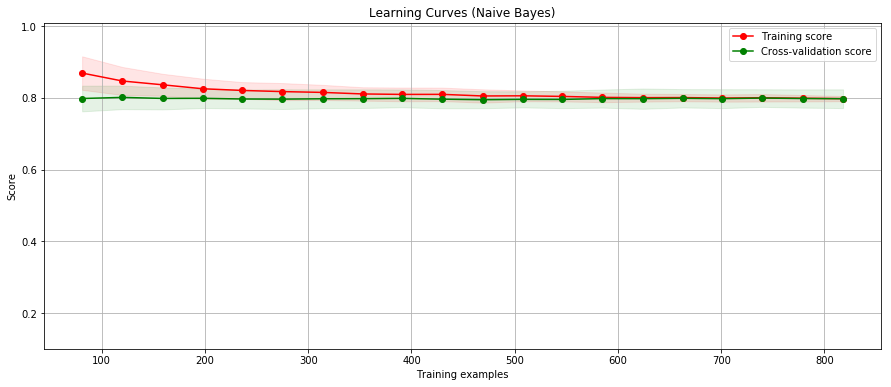

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.10, 1.0, 20)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    print('learning curve')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_weighted')
    print('learning curve2')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curve (Random Forest)"
# Cross validation with 40 splits,  each time with 20% as validation set.
cv = StratifiedShuffleSplit(n_splits=40, test_size=0.2, random_state=7)
estimator = RandomForestClassifier(max_depth=10,random_state=101, max_features=None, min_samples_leaf=3)
print('estimator 1')
plot_learning_curve(estimator, title, X, Y, ylim=(0.1, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (Naive Bayes)"
cv = StratifiedShuffleSplit(n_splits=40, test_size=0.2, random_state=7)

estimator = GaussianNB()
print('estimator 2')
plot_learning_curve(estimator, title, X, Y, (0.1, 1.01), cv=cv, n_jobs=4)


plt.show()

15
cols: [33 63 55 25 30 62 40 4 60 39 32 36 61 11 34]
Feature ranking:
15
1. feature 28 (0.014339)
2. feature 55 (0.015023)
3. feature 47 (0.016081)
4. feature 20 (0.016917)
5. feature 25 (0.020884)
6. feature 54 (0.023463)
7. feature 34 (0.023817)
8. feature 2 (0.023952)
9. feature 52 (0.026650)
10. feature 33 (0.031055)
11. feature 27 (0.044214)
12. feature 31 (0.059913)
13. feature 53 (0.076537)
14. feature 9 (0.086368)
15. feature 29 (0.151612)


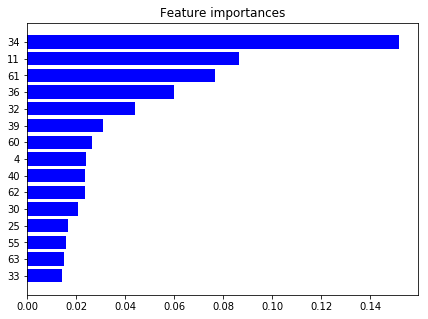

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
#Compute feature importances
forest = ExtraTreesClassifier()
forest.fit(X, Y)
columns=np.array(xfNew.columns)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
indices=indices[0:15]
indices=indices[::-1]
print(len(indices))

col=columns[indices]
print('cols:', col)
# Print the feature ranking
print("Feature ranking:")
lenx=15
print(len(range(lenx)))
for f in range(lenx):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(7,5))
plt.title("Feature importances")
plt.barh(range(lenx), importances[indices],
       color="b", align="center")
plt.yticks(range(lenx), col)
#plt.xlim([-1, lenx])
plt.show()